# Electrification of Heat: Building source input/output table
The purpose of this notebook is to build the table that will be used to calculate the output of the EoH programme. Each row in the final table will represent a specific intput and output, so any input should be mapped on a row of the output table. 

In [1]:
import os
import numpy as np
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from eoh_table_aux import create_output_table, get_calc_outputs
from sqlalchemy import create_engine
from sqlalchemy.types import INT, SMALLINT

In [2]:
# 2022/05/09 - Cost savings are not being included due to volatility in fuel prices
# To add them back in change the flag include_running_cost_comparison to True
include_running_cost_comparison = False

In [3]:
# Make a dataframe with the required rows and columns
df_out = create_output_table()

In [4]:
# Add calculated cost and CO2 savings to the dataframe
df_out = get_calc_outputs(df_out, include_running_cost_comparison)

#### Score output table

In [5]:
# scoring: select from table, run label encoding convert to strings
le = {} # one hot encoding dictionary of transformations
d_model_in = {}
model1_cols = ['House_Size','House_Age', 'House_Form', 'Wall_Type']
cat_cols =  {'House_Size':'tfa_bin','House_Age':'House_Age','House_Type':'House_Form','Wall_Type':'Wall_Type'}
X_score = df_out.loc[
    (df_out['House_Form'].isin(['Detached', 'Flat/Apartment','Mid-Terrace','Semi-Detached','Maisonette']))&
    (df_out['House_Size']!='Don\'t know'), model1_cols]
X_score.loc[X_score['House_Form'].isin(['Flat/Apartment','Maisonette']),'House_Type'] = 'Flat/Apartment'
score_ind = X_score.index
d_score = {}
for cat_col in model1_cols:
    le[cat_col] = load('model_artefacts/le_'+cat_col+'.joblib')
    le[cat_col].fit(X_score[cat_col].values)
    d_score[cat_col] = le[cat_col].transform(X_score[cat_col].values)

In [6]:
# Run get_dummies and pass into model
X_score = pd.get_dummies(pd.DataFrame(d_score).astype(str)).values
scaler = load('model_artefacts/scaler.joblib')
X_score = scaler.transform(X_score)

In [7]:
clf = load('model_artefacts/selected_model.joblib') 

In [8]:
# Predict ashp sizes from model (built in hp_models5.ipynb)
y_score = clf.predict(X_score)
df_out.loc[score_ind,'lt_ashp'] = y_score
df_out.loc[score_ind,'ht_ashp'] = y_score

In [9]:
# Set some standard ashp sizes
df_out.loc[df_out['House_Size']=='<50m2', 'lt_ashp'] = 1
df_out.loc[df_out['House_Size']=='<50m2', 'ht_ashp'] = 1
df_out.loc[df_out['House_Form']=='Park Home', 'lt_ashp'] = np.nan
df_out.loc[df_out['House_Form']=='Park Home', 'ht_ashp'] = np.nan

In [10]:
# GSHP size
df_out['gshp'] = np.nan
# The model used above to calculated ASHP sizes is built from all HP data. So can be used for GSHPs too
df_out.loc[score_ind,'gshp'] = y_score
# We have a separate requirement now to cost heat pumps for flats differently, so these are given a separate code of 4
df_out.loc[(df_out['gshp_suitable']==1)&(df_out['House_Form'].isin(['Flat/Apartment','Maisonette'])),'gshp'] = 4

# Make sure homes that aren't suitable aren't given a gshp
df_out.loc[(df_out['gshp_suitable']!=1), 'gshp'] = np.nan

In [11]:
#### Hybrid size
df_out['hhp'] = np.nan
df_out.loc[df_out['hhp_suitable']==1, 'hhp'] = 1

In [12]:
# Load installation & equipment costs as calculated in hp_model5.ipynb from files
df_ashp_cost = pd.read_csv('ashp_costs_table.csv')
df_ht_ashp_cost = pd.read_csv('ht_ashp_costs_table.csv')
df_gshp_cost = pd.read_csv('gshp_costs_table.csv')

In [13]:
# Set equipment and installation costs
df_out['lt_ashp_equip_cost_min'] = np.nan
df_out.loc[df_out['lt_ashp']==1, 'lt_ashp_equip_cost_min'] = df_ashp_cost.iloc[0][0]
df_out.loc[df_out['lt_ashp']==2, 'lt_ashp_equip_cost_min'] = df_ashp_cost.iloc[1][0]
df_out.loc[df_out['lt_ashp']==3, 'lt_ashp_equip_cost_min'] = df_ashp_cost.iloc[2][0] 
df_out['lt_ashp_equip_cost_max'] = np.nan
df_out.loc[df_out['lt_ashp']==1, 'lt_ashp_equip_cost_max'] = df_ashp_cost.iloc[0][1]
df_out.loc[df_out['lt_ashp']==2, 'lt_ashp_equip_cost_max'] = df_ashp_cost.iloc[1][1]
df_out.loc[df_out['lt_ashp']==3, 'lt_ashp_equip_cost_max'] = df_ashp_cost.iloc[2][1]

df_out['ht_ashp_equip_cost_min'] = np.nan
df_out.loc[df_out['ht_ashp']==1, 'ht_ashp_equip_cost_min'] = df_ht_ashp_cost.iloc[0][0]
df_out.loc[df_out['ht_ashp']==2, 'ht_ashp_equip_cost_min'] = df_ht_ashp_cost.iloc[1][0]
df_out.loc[df_out['ht_ashp']==3, 'ht_ashp_equip_cost_min'] = df_ht_ashp_cost.iloc[2][0]
df_out['ht_ashp_equip_cost_max'] = np.nan
df_out.loc[df_out['ht_ashp']==1, 'ht_ashp_equip_cost_max'] = df_ht_ashp_cost.iloc[0][1]
df_out.loc[df_out['ht_ashp']==2, 'ht_ashp_equip_cost_max'] = df_ht_ashp_cost.iloc[1][1]
df_out.loc[df_out['ht_ashp']==3, 'ht_ashp_equip_cost_max'] = df_ht_ashp_cost.iloc[2][1]

df_out['gshp_equip_cost_min'] = np.nan
df_out.loc[df_out['gshp']==1, 'gshp_equip_cost_min'] = df_gshp_cost.loc[0][0]
df_out.loc[df_out['gshp']==2, 'gshp_equip_cost_min'] = df_gshp_cost.loc[1][0]
df_out.loc[df_out['gshp']==3, 'gshp_equip_cost_min'] = df_gshp_cost.loc[2][0]
df_out.loc[df_out['gshp']==4, 'gshp_equip_cost_min'] = df_gshp_cost.loc[3][0]
df_out['gshp_equip_cost_max'] = np.nan
df_out.loc[df_out['gshp']==1, 'gshp_equip_cost_max'] = df_gshp_cost.loc[0][1]
df_out.loc[df_out['gshp']==2, 'gshp_equip_cost_max'] = df_gshp_cost.loc[1][1]
df_out.loc[df_out['gshp']==3, 'gshp_equip_cost_max'] = df_gshp_cost.loc[2][1]
df_out.loc[df_out['gshp']==4, 'gshp_equip_cost_max'] = df_gshp_cost.loc[3][1]

df_out['hhp_equip_cost_min'] = np.nan
df_out.loc[df_out['hhp_suitable']==1, 'hhp_equip_cost_min'] = 5500
df_out['hhp_equip_cost_max'] = np.nan
df_out.loc[df_out['hhp_suitable']==1, 'hhp_equip_cost_max'] = 12500

In [14]:
# Home improvements - Required or not
# For heat pumps (columns starting "hp_")
df_out['hp_insulation_upgrade'] = 2 # not required
df_out.loc[(df_out['Wall_Type']=='Solid - uninsulated')|(df_out['Wall_Type']=='Cavity - unfilled'),
           'hp_insulation_upgrade'] = 1 # required
df_out['hp_radiator_upgrade'] = 1 # maybe required
df_out['hp_dbl_glazing_upgrade'] = 2
df_out.loc[df_out.Glazing=='Single','hp_dbl_glazing_upgrade'] = 1
df_out['hp_loft_ins_upgrade'] = 2
df_out.loc[df_out['Roof_Type'].isin(
    ['Loft - uninsulated', 'Loft - partially insulated or unknown amount of insulation',
     'A flat roof - uninsulated', 'Loft conversion - uninsulated']),'hp_loft_ins_upgrade'] = 1 # required

# For hybrid heat pumps  (columns starting "hhp_")
df_out['hhp_insulation_upgrade'] = 2 # not required
df_out.loc[(df_out['Wall_Type']=='Solid - uninsulated')|(df_out['Wall_Type']=='Cavity - unfilled'), 
           'hhp_insulation_upgrade'] = 1 # required
df_out['hhp_radiator_upgrade'] = 1 # required
df_out['hhp_dbl_glazing_upgrade'] = 2
df_out.loc[df_out.Glazing=='Single','hhp_dbl_glazing_upgrade'] = 1
df_out['hhp_loft_ins_upgrade'] = 2
df_out.loc[df_out['Roof_Type'].isin(
    ['Loft - uninsulated', 'Loft - partially insulated or unknown amount of insulation',
     'A flat roof - uninsulated', 'Loft conversion - uninsulated']),'hhp_loft_ins_upgrade'] = 1 # required

In [15]:
# Loft insulation - costs
df_out['loft_insulation_upgrade_cost'] = np.nan

loft_ins_group0 = ['Loft - insulated','A flat roof - insulated','Loft conversion - insulated',
                   'No roof (ground or mid-floor flat)']
loft_ins_group1 = ['Loft - uninsulated', 'Loft - partially insulated or unknown amount of insulation']
loft_ins_group2 = ['Loft conversion - uninsulated']
loft_ins_group3 = ['A flat roof - uninsulated']
                   
df_out.loc[df_out['Roof_Type'].isin(loft_ins_group0), 'loft_insulation_upgrade_cost'] = np.nan
df_out.loc[df_out['Roof_Type'].isin(loft_ins_group1), 'loft_insulation_upgrade_cost'] = 225
df_out.loc[df_out['Roof_Type'].isin(loft_ins_group2), 'loft_insulation_upgrade_cost'] = 2100
df_out.loc[df_out['Roof_Type'].isin(loft_ins_group3), 'loft_insulation_upgrade_cost'] = 1175

In [16]:
# Wall insulation costs
df_out['wall_insulation_upgrade_cost'] = np.nan
df_out.loc[df_out['Wall_Type']=='Solid - uninsulated', 'wall_insulation_upgrade_cost'] = 9000
df_out.loc[df_out['Wall_Type']=='Cavity - unfilled', 'wall_insulation_upgrade_cost'] = 1000

In [17]:
# Glazing costs
df_out['dbl_glazing_upgrade_cost'] = np.nan
df_out.loc[df_out['Glazing']=='Single', 'dbl_glazing_upgrade_cost'] = 4900

In [18]:
# Radiator upgrade costs
df_out['radiator_upgrade_cost'] = 300

In [19]:
# parkhomes get all upgrades null as they are unsuitable
df_out.loc[df_out['lt_ashp_suitable']==2,
       ['hp_insulation_upgrade','hp_radiator_upgrade','hp_dbl_glazing_upgrade',
        'hp_loft_ins_upgrade', 'wall_insulation_upgrade_cost', 'dbl_glazing_upgrade_cost',
        'loft_insulation_upgrade_cost', 'radiator_upgrade_cost']] = np.nan
df_out.loc[df_out['lt_ashp_suitable']==2,
       ['hhp_insulation_upgrade','hhp_radiator_upgrade','hhp_dbl_glazing_upgrade',
        'hhp_loft_ins_upgrade', 'wall_insulation_upgrade_cost', 'dbl_glazing_upgrade_cost',
        'loft_insulation_upgrade_cost', 'radiator_upgrade_cost']] = np.nan

In [20]:
# Define dicts to convert readable strings into database code values
house_type_dict = {'Detached':1,'Semi-Detached':2,'Mid-Terrace':3,'Flat/Apartment':4,
                   'Park Home':5, 'Maisonette':4}
wi_dict = {'Solid - uninsulated':1,'Solid - Insulated':2,'Cavity - unfilled':3,'Cavity - filled':4}
age_dict = {'Before 1900':1,'1900 - 1929':2,'1930 - 1949':3,'1950 - 1966':4,'1967 - 1975':5,
            '1976 - 1982':6,'1983 - 1990':7,'1991 - 1995':8,'1996 - 2002':9,'2003 - 2006':10,
            '2007 - 2011':11,'2012+':12}
size_dict = {'<50m2':1,'50-70m2':2,'70-90m2':3,'90-110m2':4,'110-200m2':5,'200-300m2':6,'300-400m2':7}
roof_type_dict = {'Loft - uninsulated':1, 'Loft - partially insulated or unknown amount of insulation':1, 
                  'Loft - insulated':4,'A flat roof - uninsulated':2, 'A flat roof - insulated':4,
                  'Loft conversion - uninsulated':3, 'Loft conversion - insulated':4, 
                  'No roof (ground or mid-floor flat)':4}
glaze_dict = {'Single':1,'Double':2,'Triple':2}
gas_dict = {'Yes':1,'No':2}
outside_dict = {'Yes':1,'No':2}
current_heat_dict = {'Natural Gas':1,'Oil':2,'LPG':3,'Electricity':4,
                     'Non-renewable solid fuel (e.g. coal)':5, 'Biomass / Biogas': 6}

In [21]:
df_out.rename(columns={'House_Form':'House_Type'},inplace=True)

In [22]:
# Replace strings with database codes
df_out['House_Type'].replace(house_type_dict,inplace=True)
df_out['Wall_Type'].replace(wi_dict,inplace=True)
df_out['House_Age'].replace(age_dict,inplace=True)
df_out['House_Size'].replace(size_dict,inplace=True)
df_out['Roof_Type'].replace(roof_type_dict,inplace=True)
df_out['Glazing'].replace(glaze_dict,inplace=True)
df_out['Gas_Supply'].replace(gas_dict,inplace=True)
df_out['Outside_Space'].replace(outside_dict,inplace=True)
df_out['Current_System'].replace(current_heat_dict,inplace=True)

In [23]:
df_out = df_out.where(pd.notna(df_out), None)
df_out = df_out.where(pd.notnull(df_out), None)
print(len(df_out), len(df_out.drop_duplicates()))

967680 322560


In [24]:
df_out.drop(columns=['key'], inplace=True)

In [25]:
# Write out the table to file, both as database and csv
df_out = df_out.drop_duplicates()
df_out.to_csv('eoh.csv',index=False)
engine = create_engine('sqlite:///eoh9.db', echo=False)
con = engine.connect()
df_out.to_sql('eoh', con=con, if_exists='replace', index=False, dtype={col_name: SMALLINT for col_name in df_out})
con.close()

### Tests

Here we run some sanity checks on the database

#### Duplicates

In [26]:
in_cols = ['House_Type','Wall_Type', 'House_Age', 'House_Size', 'Roof_Type', 
           'Glazing', 'Gas_Supply', 'Outside_Space', 'Current_System']
for hp in ['lt_ashp', 'ht_ashp', 'gshp', 'hhp']:
    print('Finding possible duplicates for '+ hp )
    msk = df_out.House_Type!=5 # exclude parkhomes
    print('Total number of records excluding park homes: ', len(df_out[msk]))
    df_test = df_out.loc[msk, in_cols+[hp]].groupby(by=in_cols,as_index=False).count()
    print('Possible duplicates',  len(df_test[df_test[hp]==2]))
    print('% of duplicates: ', len(df_test[df_test[hp]==2]/len(df_out[msk])))
    display(df_test[df_test[hp]==1].describe())

Finding possible duplicates for lt_ashp
Total number of records excluding park homes:  258048
Possible duplicates 0
% of duplicates:  0


,House_Type,Wall_Type,House_Age,House_Size,Roof_Type,Glazing,Gas_Supply,Outside_Space,Current_System,lt_ashp
count,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.0
mean,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.500000,3.500000,1.0
std,1.118036,1.118036,3.452059,2.000004,1.118036,0.500001,0.500001,0.500001,1.707828,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,1.750000,1.750000,3.750000,2.000000,1.750000,1.000000,1.000000,1.000000,2.000000,1.0
50%,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.500000,3.500000,1.0
75%,3.250000,3.250000,9.250000,6.000000,3.250000,2.000000,2.000000,2.000000,5.000000,1.0
max,4.000000,4.000000,12.000000,7.000000,4.000000,2.000000,2.000000,2.000000,6.000000,1.0


Finding possible duplicates for ht_ashp
Total number of records excluding park homes:  258048
Possible duplicates 0
% of duplicates:  0


,House_Type,Wall_Type,House_Age,House_Size,Roof_Type,Glazing,Gas_Supply,Outside_Space,Current_System,ht_ashp
count,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.000000,258048.0
mean,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.500000,3.500000,1.0
std,1.118036,1.118036,3.452059,2.000004,1.118036,0.500001,0.500001,0.500001,1.707828,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,1.750000,1.750000,3.750000,2.000000,1.750000,1.000000,1.000000,1.000000,2.000000,1.0
50%,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.500000,3.500000,1.0
75%,3.250000,3.250000,9.250000,6.000000,3.250000,2.000000,2.000000,2.000000,5.000000,1.0
max,4.000000,4.000000,12.000000,7.000000,4.000000,2.000000,2.000000,2.000000,6.000000,1.0


Finding possible duplicates for gshp
Total number of records excluding park homes:  258048
Possible duplicates 0
% of duplicates:  0


,House_Type,Wall_Type,House_Age,House_Size,Roof_Type,Glazing,Gas_Supply,Outside_Space,Current_System,gshp
count,129024.000000,129024.000000,129024.000000,129024.000000,129024.000000,129024.000000,129024.000000,129024.0,129024.000000,129024.0
mean,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.0,3.500000,1.0
std,1.118038,1.118038,3.452066,2.000008,1.118038,0.500002,0.500002,0.0,1.707832,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0
25%,1.750000,1.750000,3.750000,2.000000,1.750000,1.000000,1.000000,1.0,2.000000,1.0
50%,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.500000,1.0,3.500000,1.0
75%,3.250000,3.250000,9.250000,6.000000,3.250000,2.000000,2.000000,1.0,5.000000,1.0
max,4.000000,4.000000,12.000000,7.000000,4.000000,2.000000,2.000000,1.0,6.000000,1.0


Finding possible duplicates for hhp
Total number of records excluding park homes:  258048
Possible duplicates 0
% of duplicates:  0


,House_Type,Wall_Type,House_Age,House_Size,Roof_Type,Glazing,Gas_Supply,Outside_Space,Current_System,hhp
count,129024.000000,129024.000000,129024.000000,129024.000000,129024.000000,129024.000000,129024.0,129024.000000,129024.000000,129024.0
mean,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.0,1.500000,3.500000,1.0
std,1.118038,1.118038,3.452066,2.000008,1.118038,0.500002,0.0,0.500002,1.707832,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
25%,1.750000,1.750000,3.750000,2.000000,1.750000,1.000000,1.0,1.000000,2.000000,1.0
50%,2.500000,2.500000,6.500000,4.000000,2.500000,1.500000,1.0,1.500000,3.500000,1.0
75%,3.250000,3.250000,9.250000,6.000000,3.250000,2.000000,1.0,2.000000,5.000000,1.0
max,4.000000,4.000000,12.000000,7.000000,4.000000,2.000000,1.0,2.000000,6.000000,1.0


#### NaNs
Check that the only NaNs are park homes

In [27]:
df_out.loc[(df_out['ht_ashp'].isna()) & ~(df_out['House_Type']=='House Park'), ['lt_ashp', 'ht_ashp', 'gshp', 'hhp']].drop_duplicates()

,lt_ashp,ht_ashp,gshp,hhp
774144,NaN,NaN,NaN,NaN


#### 300-400 sqm houses
Since they are rare check that all got a hp. Also check the distribution

In [28]:
print('NaN count: ', len(df_out.loc[(df_out['House_Size']==7) & ~(df_out['House_Type']==5) &(df_out['lt_ashp'].isna())]))
display(df_out.loc[(df_out['House_Size']==7) & ~(df_out['House_Type']==5), 
                   ['House_Type', 'House_Age', 'lt_ashp']].value_counts().sort_index())

NaN count:  0


House_Type  House_Age  lt_ashp
1           1          2.0        768
            2          1.0        768
            3          1.0        768
            4          1.0        768
            5          1.0        768
            6          1.0        768
            7          1.0        384
                       3.0        384
            8          1.0        768
            9          1.0        768
            10         1.0        768
            11         1.0        768
            12         1.0        768
2           1          2.0        768
            2          1.0        768
            3          1.0        768
            4          1.0        768
            5          1.0        768
            6          1.0        768
            7          1.0        768
            8          1.0        768
            9          1.0        768
            10         1.0        768
            11         1.0        768
            12         1.0        768
3           1      

#### General HP distribution across house types

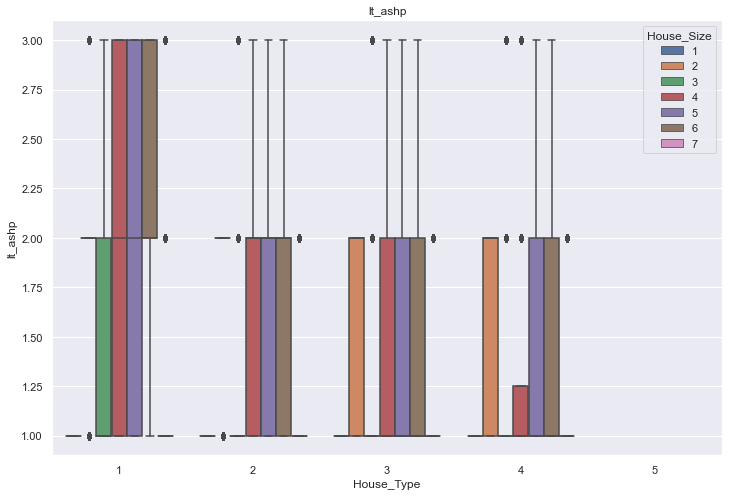

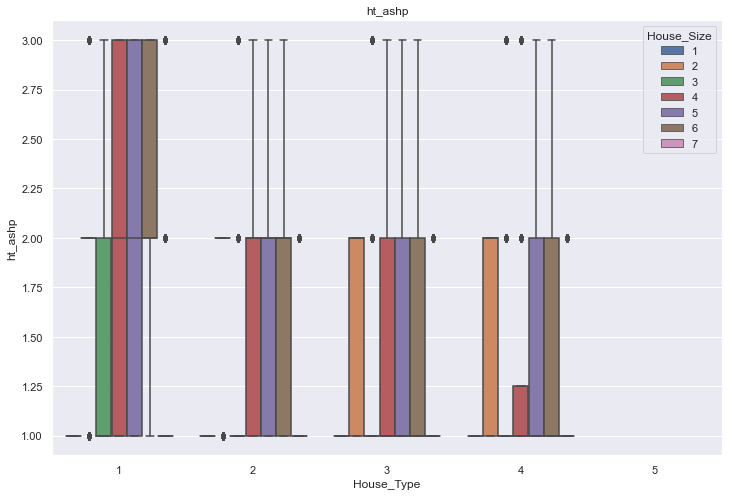

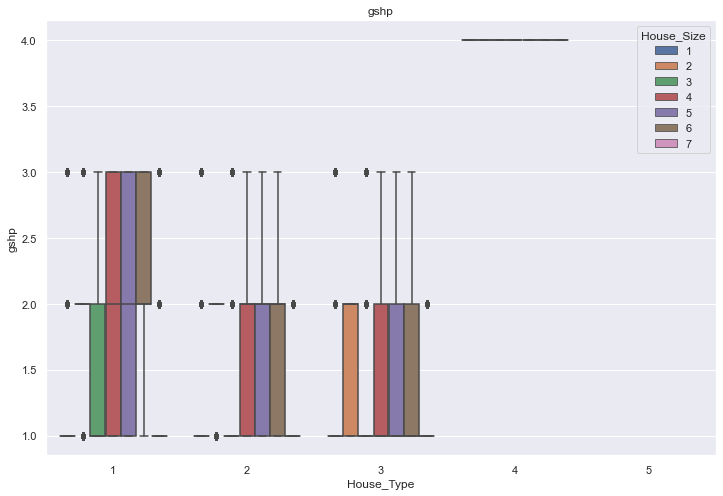

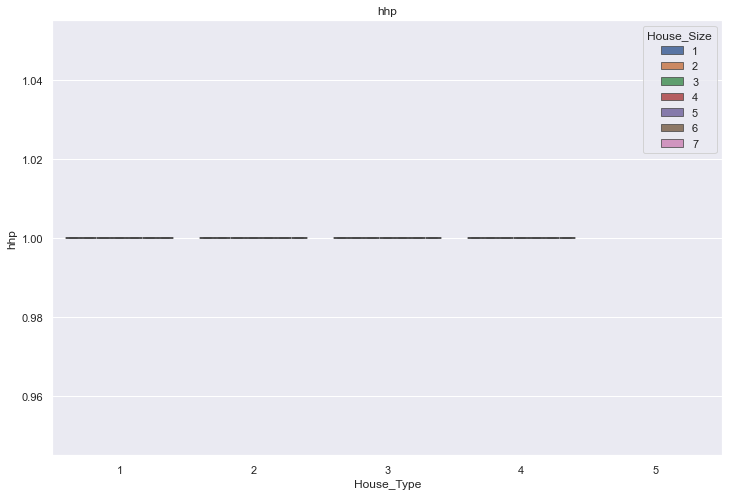

In [29]:
sns.set(rc = {'figure.figsize':(12,8)})
hps = ['lt_ashp', 'ht_ashp', 'gshp', 'hhp']
for hp in hps:
    plt.figure()
    sns.boxplot(data=df_out, y=hp,x='House_Type', hue='House_Size', showfliers=True)
    plt.title(hp)
    plt.show()
    plt.close()


#### GSHP

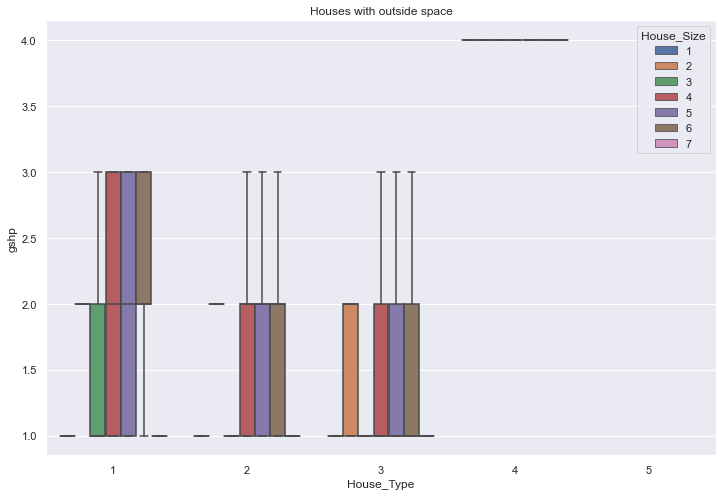

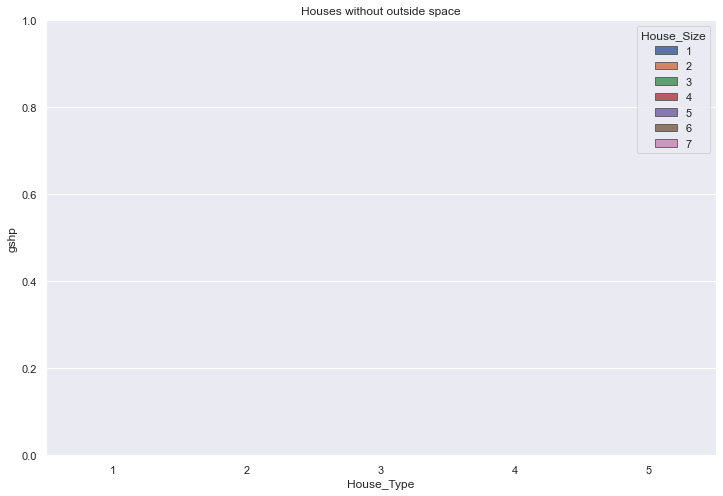

In [30]:
for i in range(1,3):
    msk = df_out.Outside_Space==i
    df_test = df_out.loc[msk]
    plt.figure()
    sns.boxplot(data=df_test, y='gshp',x='House_Type', hue='House_Size', showfliers=False)
    if i==1:
        plt.title('Houses with outside space')
    elif i==2:
        plt.title('Houses without outside space')
    plt.show()
    plt.close()


In [31]:
#### HHP

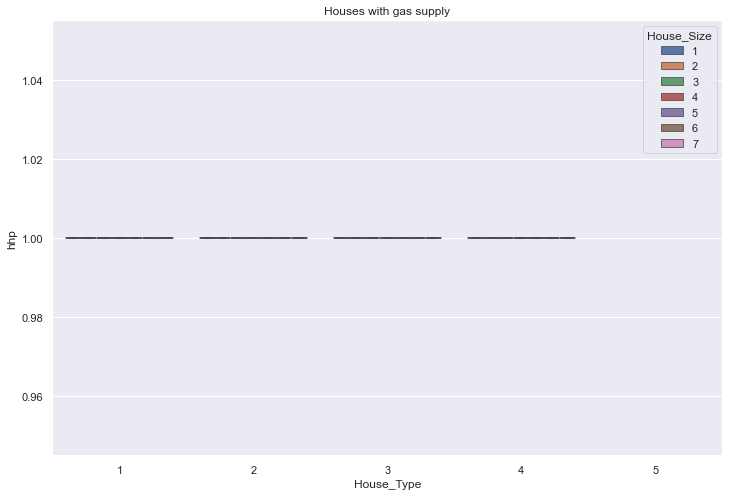

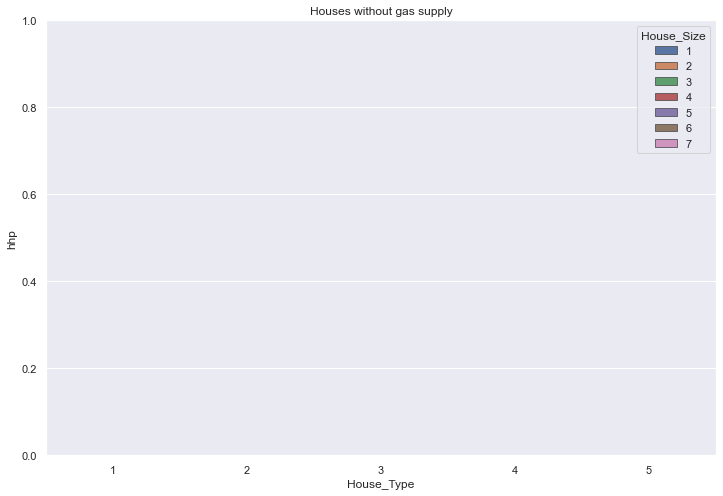

In [32]:
for i in range(1,3):
    msk = df_out.Gas_Supply==i
    df_test = df_out.loc[msk]
    plt.figure()
    sns.boxplot(data=df_test, y='hhp',x='House_Type', hue='House_Size', showfliers=False)
    if i==1:
        plt.title('Houses with gas supply')
    elif i==2:
        plt.title('Houses without gas supply')
    plt.show()
    plt.close()

#### Example

In [33]:
df_out[(df_out['House_Type']==4) & (df_out['Wall_Type']==1) & 
       (df_out['House_Age']==1) & (df_out['House_Size']==1) & 
       (df_out['Roof_Type']==4) & (df_out['Glazing']==1) & 
       (df_out['Gas_Supply']==2) & (df_out['Outside_Space']==1) & 
       (df_out['Current_System']==1)].T

,580764
House_Type,4.00
Wall_Type,1.00
House_Age,1.00
House_Size,1.00
Roof_Type,4.00
Glazing,1.00
Gas_Supply,2.00
Outside_Space,1.00
Current_System,1.00
lt_ashp_suitable,1.00
